In [8]:
from ctraptools.kymos.detect import Detector
from lumicks import pylake

import ctraptools.kymos.stepfinding as ksf
import ctraptools.kymos.io as kio
import os

In [15]:
# Parameters
path = "C:\\Users\\steph\\Documents\\People\\CTrapTools\\20220616-150818 Kymograph 7.h5"
channel = 0

In [16]:
# Loading kymograph as image
if os.path.splitext(path)[1] == ".tif":
    image = kio.read_image(path,channel,x_range=None)
elif os.path.splitext(path)[1] == ".h5" or os.path.splitext(path)[1] == ".hdf5":
    file = pylake.File(path)
    kymo = next(iter(file.kymos.values()))
    image = kymo.get_image()[:,:,channel]

rootpath = os.path.dirname(path)+'/'
rootname = os.path.basename(os.path.splitext(path)[0])

In [25]:
# Initialising Detector
half_t_w = 3
detector = Detector(half_t_w=half_t_w,peak_det_thresh = 0.06, n_max=10, c_ub=5, c_def=3, min_track_length = 10, track_heritage_weight=100)

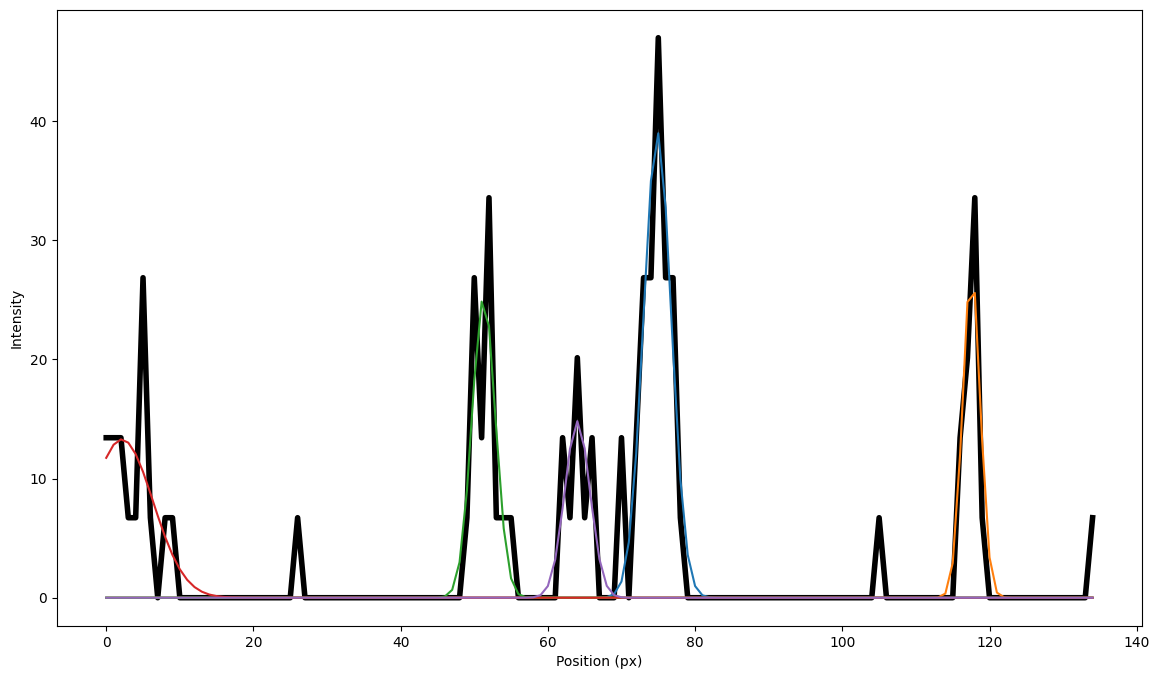

In [26]:
# (Optional) Testing fit parameters
fr = 396
peaks = detector.fit_peaks(image,fr)
kio.plot_gauss_for_frame(peaks,fr,image,half_t_w=half_t_w)

In [27]:
# Detect peaks and track
tracks = detector.detect(image)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1576/1576 [09:10<00:00,  2.86it/s]


In [28]:
# Measuring intensity
for track in tracks.values():
    track.measure_intensity(image)

# Step fitting (to be added later)
# ksf.fit_steps(tracks,image)

# Saving files
kio.save_overlay(tracks,image,rootpath+rootname+'_C'+str(channel)+"_overlay")
kio.write_traces(tracks,rootpath+rootname+'_C'+str(channel)+"_traces")
kio.save_plots(tracks,rootpath+rootname+'_C'+str(channel)+"_traces")
# kio.write_change_points(tracks,rootpath+rootname+'_C'+str(channel)+'_steps')